In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
outputVar = 'Risk'

X_train = train.drop(columns= [outputVar],axis=1)
y_train = train[outputVar]

X_test = test.drop(columns= [outputVar],axis=1)
y_test = test[outputVar]

## Logistic Regression

In [4]:
import skopt

In [5]:
from skopt.space import Integer, Real

space  = [Integer(1, 10000, name='max_iter')]

In [6]:
from sklearn.linear_model import LogisticRegression

from skopt.utils import use_named_args
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

myRandom = 0
@use_named_args(space)
def objective(**params):
  tempLogreg = LogisticRegression(**params, random_state = 0)

  global myRandom
  myCV = StratifiedKFold(n_splits=10, shuffle=True, random_state=myRandom)
  scores = cross_val_score(tempLogreg, X_train, y_train, scoring = 'roc_auc', cv = myCV)
  myRandom = myRandom + 1
  result = scores.mean()
  return -result

In [7]:
from skopt import gp_minimize

opt = gp_minimize(objective, space, n_calls=150, random_state=0, verbose = False, n_jobs = -1)

In [8]:
opt.x

[9437]

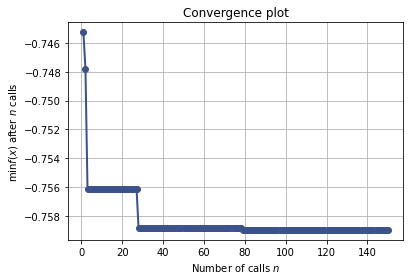

In [9]:
from skopt.plots import plot_convergence

_ = plot_convergence(opt)

In [10]:
logReg = LogisticRegression(max_iter = opt.x[0])

logReg.fit(X_train, y_train)

LogisticRegression(max_iter=9437)

In [11]:
from sklearn.metrics import roc_auc_score

myCV = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
myScore = cross_val_score(logReg, X_train, y_train, scoring = 'roc_auc', cv = myCV).mean()

print('The cross-validation-score of this classifier is ' +
      str(myScore) + 
      ' (training set).\n')

The cross-validation-score of this classifier is 0.7452531385281385 (training set).



In [12]:
y_pred = logReg.predict(X_test)

myScore = roc_auc_score(y_test, y_pred)

print('The cross-validation-score of this classifier is ' +
      str(myScore) + 
      ' (testing set).\n')

The cross-validation-score of this classifier is 0.6517727051966975 (testing set).



In [13]:
myCoefs = logReg.coef_[0]
sort = np.argsort(np.abs(myCoefs))[::-1]
myCoefs = myCoefs[sort]

feature_names = X_train.keys()[sort]

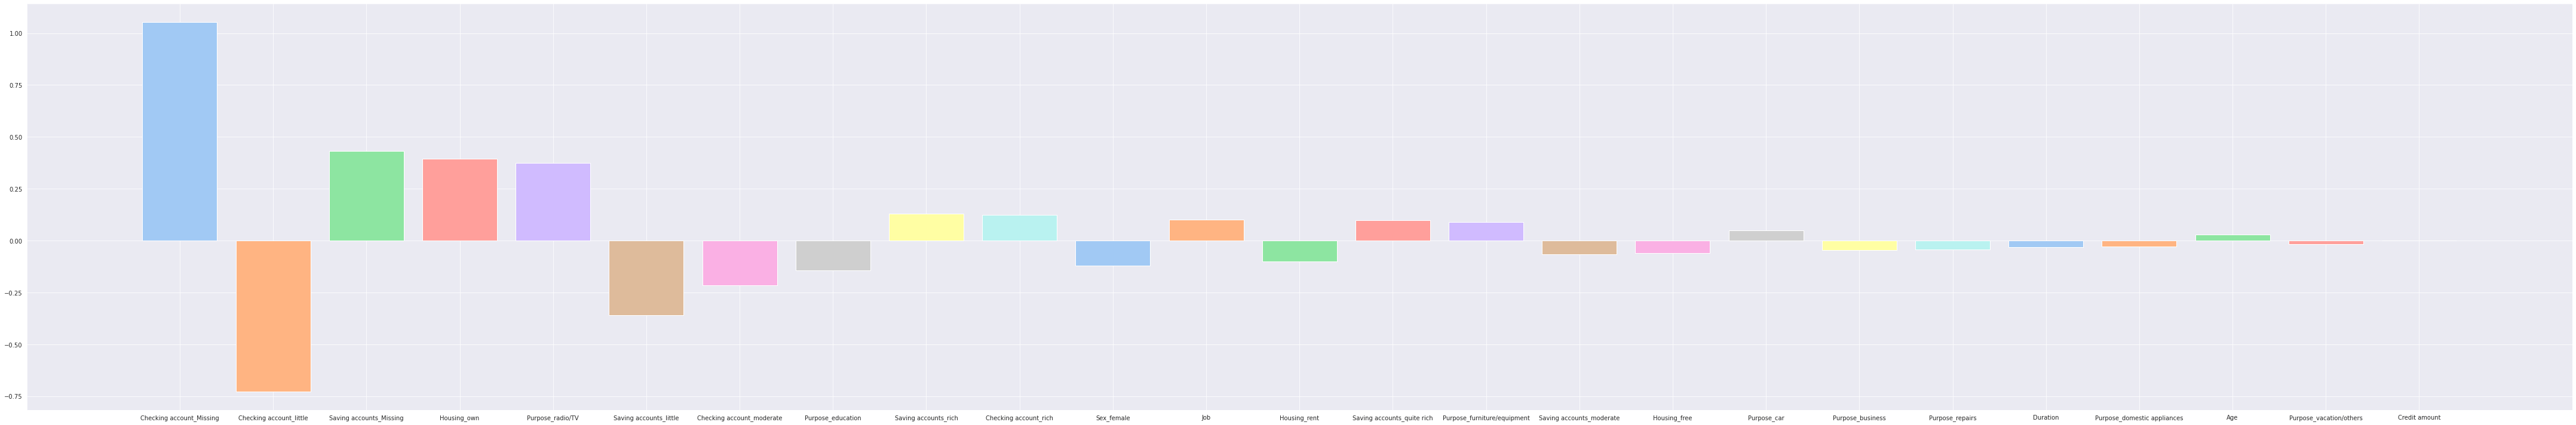

In [14]:
n = 25

sns.set_style('darkgrid')
plt.figure(figsize=(60,10), tight_layout=True)
colors = sns.color_palette('pastel')
_ = plt.bar(x = feature_names[:n], height = myCoefs[:n], color=colors[:n])

## Lasso Regression

In [15]:
space  = [Real(0.001, 0.2, name = 'C'),
         Integer(1, 10000, name='max_iter')
         ]

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

myRandom = 0

@use_named_args(space)
def objective(**params):
    lasso = LogisticRegression(**params, penalty = 'l1', solver = 'saga', random_state = 0)
    
    pipeLasso = make_pipeline(StandardScaler(), lasso)
    pipeLasso.fit(X_train, y_train)
    
    global myRandom
    myCV = StratifiedKFold(n_splits=10, shuffle=True, random_state=myRandom)
    scores = cross_val_score(pipeLasso, X_train, y_train, scoring = 'roc_auc', cv = myCV)
    myRandom = myRandom + 1
    result = scores.mean()
    return -result

In [17]:
opt = gp_minimize(objective, space, n_calls=150, random_state=0, verbose = False, n_jobs = -1)

In [18]:
opt.x

[0.14710077742531855, 10000]

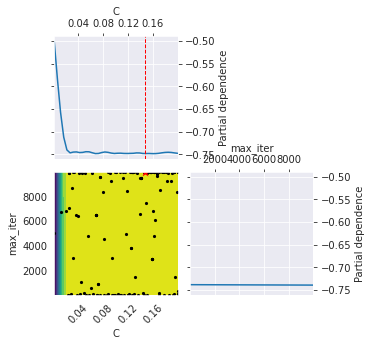

In [19]:
from skopt.plots import plot_objective

_ = plot_objective(opt)

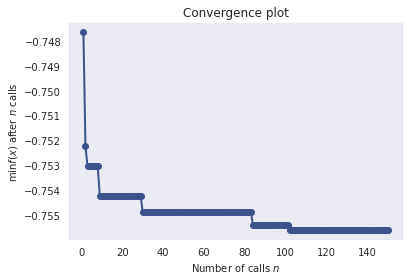

In [20]:
_ = plot_convergence(opt)

In [21]:
optLasso = LogisticRegression(penalty = 'l1', C = opt.x[0], solver = 'saga', max_iter = opt.x[1])
    
pipeLasso = make_pipeline(StandardScaler(), optLasso)
_ = pipeLasso.fit(X_train, y_train)

In [22]:
myCV = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
myScore = cross_val_score(pipeLasso, X_train, y_train, scoring = 'roc_auc', cv = myCV).mean()

print('The cross-validation-score of this classifier is ' +
      str(myScore) + 
      ' (training set).\n')

The cross-validation-score of this classifier is 0.7468374458874459 (training set).



In [23]:
y_pred = pipeLasso.predict(X_test)

myScore = roc_auc_score(y_test, y_pred)

print('The cross-validation-score of this classifier is ' +
      str(myScore) + 
      ' (testing set).\n')

The cross-validation-score of this classifier is 0.6454589606605148 (testing set).

